In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
from python_dict_wrapper import wrap

args = wrap({'features': 'airsim_02',
             'ckpt_root': '../pretrained',
             'slowfast_root': '../../slowfast',
             'ntau': 1,
             'subsample_layers': False})

from fmri_models import get_feature_model

model, _, _ = get_feature_model(args)

In [3]:
model

DorsalNet(
  (s1): ShallowNet(
    (conv1): Conv3d(3, 64, kernel_size=[5, 7, 7], stride=[1, 2, 2], padding=[2, 3, 3], bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    (dropout): Dropout3d(p=0, inplace=False)
  )
  (res0): ResBlock(
    (branch1): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=[1, 1, 1], bias=False)
    (branch1_bn): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (branch2): BottleneckTransform(
      (a): Conv3d(64, 8, kernel_size=[1, 1, 1], stride=[1, 1, 1], padding=[0, 0, 0], bias=False)
      (a_bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv3d(8, 8, kernel_size=[1, 3, 3], stride=[1, 1, 1], padding=[0, 1, 1], dilation=[1

In [436]:
import lucentpatch
import lucentpatch.transform

from lucentpatch.render import render_vis
from lucentpatch.objectives import neuron, slow, tv_slow, intensity_preservation
from lucent.optvis.objectives import channel
from lucent.optvis import param
import lucent
import lucent.optvis
import lucent.optvis.transform

import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def get_anim(result, size=4, norm=False):
    fig = plt.figure(figsize=(size, size))
    ax = plt.gca()
    im = plt.imshow([[1]])
    plt.axis('off')

    rg = None
    if norm:
        rg = [result.min(), result.max()]

    def drawframe(n):
        if n >= nt:
            n = nt - 1
        else:
            im.set_data(result.transpose((2, 3, 1, 0))[:, :, :, n])
        if norm:
            im.set_clim(rg)
        return (im)

    # blit=True re-draws only the parts that have changed.
    anim = animation.FuncAnimation(fig, drawframe, frames=nt*2, interval=100, blit=False)
    plt.close()
    return anim

layer_name = 'res0_relu'
for filt in range(64):
    nt = 7
    device = 'cuda'
    batch_param_f = lambda: param.image(60, batch=nt, fft=False)

    # Most important layers: layer2_1_relu, layer3_0_relu, layer3_1_relu
    obj = neuron(layer_name, filt, (1, 1)) #+ 2 * slow('input') + 2 * tv_slow('input') #+ 5 * intensity_preservation('input', 112 // 4, 112)

    model = model.to(device).eval()
    result = render_vis(model, 
                        obj, 
                        batch_param_f, 
                        show_image=False, 
                        show_inline=False, 
                        thresholds=(128,), 
                        fixed_image_size=True,
                        preprocess=False,
                        transforms=[lucentpatch.transform.normalize(),
                                    lucent.optvis.transform.pad(12, mode="constant", constant_value=0.5),
                                    lucent.optvis.transform.jitter(8),
                                    lucent.optvis.transform.random_scale([1 + (i - 5) / 50.0 for i in range(11)]),
                                    lucent.optvis.transform.random_rotate(list(range(-10, 11)) + 5 * [0]),
                                    lucent.optvis.transform.jitter(4),
                                    #lucentpatch.transform.loop(3)
                                    ],
                        )

    anim = get_anim(result[0], 1.5)
    anim.save(f'figures/{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
    HTML(anim.to_html5_video())

    #base_mask = result[0].max(axis=0).max(axis=0)
    #mask = (base_mask.mean(axis=0, keepdims=True) > .51) * (base_mask.mean(axis=1, keepdims=True) > .51)

  0%|          | 0/128 [00:00<?, ?it/s]


IndexError: index 32 is out of bounds for dimension 1 with size 32

In [420]:
112/2+10

66.0

In [432]:
from lucent.optvis.param.spatial import pixel_image, fft_image
from lucent.optvis.param.color import to_valid_rgb

import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def deformed_image(w, h=None, sd=None, batch=None, decorrelate=True,
          fft=True, channels=None):
    if sd is None:
        sd = .01
        
    h = h or w
    batch = batch or 1
    ch = channels or 3
    shape = [1, ch, h, w]
    param_f = fft_image if fft else pixel_image
    params, image_f = param_f(shape, sd=sd)
    
    print(shape)
    #d = (torch.randn(1, h, w, 2) * sd).to(device).requires_grad_(True)
    dxy = (torch.randn(1, h // 8, w // 8, 2) * .0000001).to(device).requires_grad_(True)
    
    xi, yi = torch.meshgrid(torch.linspace(-1, 1, h), torch.linspace(-1, 1, h))
    g = torch.stack([yi, xi], dim=2)
    g = g.to(device=device).unsqueeze(0)
    
    def get_output():
        a = image_f()
        outputs = []
        for i in range(batch):
            # Upsample the displacement grid
            dxy_big = F.grid_sample(dxy.permute(0, 3, 1, 2), g, align_corners=True)
            dxy_big = dxy_big.permute(0, 2, 3, 1)
            the_im = F.grid_sample(a, 
                                   g + dxy_big * (i - batch // 2), 
                                   align_corners=True, 
                                   padding_mode='zeros')
            outputs.append(the_im)
        out = torch.cat(outputs, axis=0)
        return out
    
    return params + [dxy], get_output

batch_param_f = lambda: deformed_image(60, batch=nt, fft=False)

result = render_vis(model, 
                    obj, 
                    batch_param_f, 
                    show_image=False, 
                    show_inline=False, 
                    thresholds=(128,), 
                    fixed_image_size=True,
                    preprocess=False,
                    transforms=[],
                    )

#anim.save(f'figures/{layer_name}_{filt}.gif', writer='imagemagick', fps=12, bitrate=10000)
#HTML(anim.to_html5_video())
#anim.min()
#params, output = batch_param_f()
#plt.subplot(121)
#plt.imshow(params[0].cpu().detach().numpy()[0, :, :, :].transpose((1, 2, 0))*10 + .5)
#plt.subplot(122)
#plt.imshow(output().cpu().detach().numpy()[3, :, :, :].transpose((1, 2, 0))*10 + .5)
#params[0].shape

#anim = get_anim(result[0]*.1+.5)
#HTML(anim.to_html5_video())

  1%|          | 1/128 [00:00<00:13,  9.29it/s]

[1, 3, 60, 60]


100%|██████████| 128/128 [00:11<00:00, 10.95it/s]


In [434]:
anim = get_anim(result[0]*.1+.5, 2)
HTML(anim.to_html5_video())

In [205]:
result[0].min()

-1.3242902

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


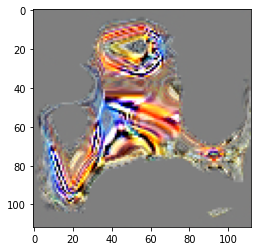

In [310]:
#plt.imshow()
plt.imshow(result[0][6, :, :, :].transpose((2, 1, 0))[:, :, :]*.3 + .5)